[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1RN93yQ0kqAwlgAQZLVs9fAezk_5DryAd?usp=sharing)

# Set Up

In [ ]:
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip > /dev/null

In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from numpy import percentile
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Data Analysis and Preprocessing

In [ ]:
# pandas couldn't identify the type of the following two columns
recs_df = pd.read_csv("recs2009_public.csv",dtype={"NOCRCASH":"object","NKRGALNC":"object"})

We take advantage of pandas profiling to get an overview of the data and a quick analysis. Due to the large size of the report, I chose minimal report without correlation calculations. I commented the following lines, since the report was too large for Google Colab to save.

In [ ]:
# profile = ProfileReport(recs_df, title="RECS Dataset Profile",minimal=True)
# profile.to_notebook_iframe()

In [ ]:
# profile.to_file("recs_report.html")

Some important insights from a glance at the report:

* over 900 columns, high dimensional data --> curse-of-dimensionality a great concern

* many columns with almost constant values (zeros for example) --> redundant columns

* no missing values reported (missing values are most likely already imputetd by the center who did the survey)

* many columns with skewed distribution, must keep an eye on these when doing regression

## Target Variable Analysis

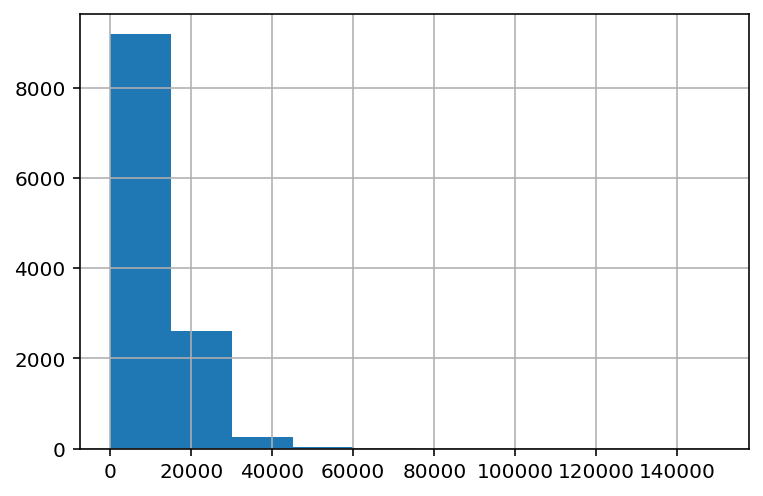

In [ ]:
recs_df['KWH'].hist()

we can see that the distribution is a bit skewed. Since our end goal is to predict this value, and it's continuous, we need a regression model. However, based on linear regression assumptions, we ideally want our target variable and predictors be normally distributed. 

## Correlations

We will have a look at the correlation among variables in our dataset.

In [ ]:
def get_high_corr_df(df,positive_threshold=0.4):
  corr = df.corr().stack().reset_index().drop_duplicates()
  corr.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']
  high_corr = corr[((corr['FEATURE_1'] != corr['FEATURE_2'] ) & ((corr['CORRELATION'] >= positive_threshold) | (corr['CORRELATION'] <= positive_threshold*-1)))]
  return high_corr

In [ ]:
high_corr = get_high_corr_df(recs_df)
high_corr[((high_corr['FEATURE_1'] == 'KWH'))]

,FEATURE_1,FEATURE_2,CORRELATION
726844,KWH,BEDROOMS,0.403322
726845,KWH,NCOMBATH,0.420556
726848,KWH,TOTROOMS,0.439167
727328,KWH,ACROOMS,0.435835
727610,KWH,TOTHSQFT,0.410385
727612,KWH,TOTCSQFT,0.484042
727621,KWH,KWHSPH,0.497684
727622,KWH,KWHCOL,0.655104
727623,KWH,KWHWTH,0.585656
727624,KWH,KWHRFG,0.638621


There is a perfect correlation of 1 between KWH and BTUEL. If we have a look at the codebook provided on the website, we'll see that they are representing the same thing (total electricity site usage), but in different units (one in kw/h and the other one in thousand BTU). Furthermore, there are columns that show categories of KWH such as electricity usage for air-conditioning. I personally think, we should drop these columns for training a prediction model, otherwise they would serve a data-leak or cheating for the model. They are part of our target variable.

In [ ]:
KWH_cheat_columns = [c for c in recs_df.columns if (("KWH" in c and len(c)>3) or "BTUEL" in c) ]
recs_df.drop(columns=KWH_cheat_columns,inplace=True)

drop id, unique value

In [ ]:
recs_df.drop(columns=["DOEID"],inplace=True)

drop the imputation flag columns, extra information that (I personally think) is irrelevant to prediction. Moreover, mostly zeros and also no noticable correlation found with "KWH" 

In [ ]:
imputation_columns = [c for c in recs_df.columns if c.startswith("Z")]
recs_df.drop(columns=imputation_columns,inplace=True)

there are some columns that almost have a constant value, such as DOLKEROTH with mostly zeros, or AGEHHMEMCAT11 with mostly -2.

First, we'll find these columns.

In [ ]:
columns_with_constant_values = []
for c in recs_df.columns:
  value_frequencies = recs_df[c].value_counts(normalize=True)
  if value_frequencies.max()>=0.85:
    columns_with_constant_values.append(c)
print(columns_with_constant_values)
print(len(columns_with_constant_values))

['METROMICRO', 'CONDCOOP', 'CONVERSION', 'ORIG1FAM', 'LOOKLIKE', 'TYPEHUQ4', 'PCTBSTHT', 'BASECL2', 'PCTBSTCL', 'FINATTRMS', 'ATTCHT2', 'PCTATTHT', 'ATTCCL2', 'PCTATTCL', 'STOVEN', 'STOVE', 'STOVEFUEL', 'OVEN', 'OVENFUEL', 'MICRO', 'TOPGRILL', 'STGRILA', 'REFRIGT1', 'HELPFRIY', 'ESFRIG2', 'TYPERFR3', 'SIZRFRI3', 'REFRIGT3', 'MONRFRI3', 'AGERFRI3', 'ESFRIG3', 'REPLCFRZ', 'HELPFRZ', 'HELPFRZY', 'UPRTFRZR2', 'SIZFREEZ2', 'FREEZER2', 'AGEFRZR2', 'HELPDWY', 'HELPCWY', 'OTHERSTB1', 'TVONWDWATCH2', 'TVONWEWATCH2', 'TVONWDWATCH3', 'TVONWEWATCH3', 'MONITOR2', 'PCSLEEP2', 'PCTYPE3', 'MONITOR3', 'TIMEON3', 'PCONOFF3', 'PCSLEEP3', 'FAX', 'COPIER', 'AQUARIUM', 'HEATHOME', 'DNTHEAT', 'EQUIPNOHEAT', 'FUELNOHEAT', 'HELPHTY', 'HEATOTH', 'REVERSE', 'WARMAIR', 'FURNFUEL', 'STEAMR', 'RADFUEL', 'PERMELEC', 'PIPELESS', 'PIPEFUEL', 'ROOMHEAT', 'RMHTFUEL', 'WOODKILN', 'HSFUEL', 'CARRYKER', 'FPFUEL', 'NGFPFLUE', 'USENGFP', 'RANGE', 'RNGFUEL', 'DIFEQUIP', 'DIFFUEL', 'NUMH2ONOTNK', 'NUMH2OHTRS', 'H2OTYPE1', 'WHE

Then, see if any of them have a meaningful correlation with our target variable.

In [ ]:
high_corr[((high_corr['FEATURE_1'] == 'KWH') & (high_corr['FEATURE_2'].isin(columns_with_constant_values)))]

,FEATURE_1,FEATURE_2,CORRELATION


We'll drop the redundant columns.

In [ ]:
recs_df.drop(columns=columns_with_constant_values,inplace=True)

now, we look for highly correlated (close to one) pairs. If such pairs exist perhaps we could get rid of one of the variables, and reduce number of columns for building a model.

In [ ]:
high_corr = get_high_corr_df(recs_df) #calculate again, after deleting so many columns
redundant_sets=[]
for i,row in high_corr[high_corr['CORRELATION']>=0.90].iterrows():
  f1 = row['FEATURE_1']
  f2 = row['FEATURE_2']
  fset = {f1,f2}
  belongs_to_sets = []
  for j in range(len(redundant_sets)):
    if len(redundant_sets[j].intersection(fset))!=0:  
      belongs_to_sets.append(j)

  if len(belongs_to_sets)==0:
    redundant_sets.append(fset)
  elif len(belongs_to_sets)==1:
    redundant_sets[belongs_to_sets[0]].update(fset)
  else:
    sets_to_merge = [redundant_sets[j] for j in belongs_to_sets]
    for sm in sets_to_merge:
      redundant_sets.remove(sm)
      fset.update(sm)
    redundant_sets.append(fset)
  

In [ ]:
for s in redundant_sets:
  print(s)

{'REPORTABLE_DOMAIN', 'REGIONC', 'DIVISION'}
{'TYPEHUQ', 'STUDIO', 'NAPTFLRS'}
{'HDD50', 'GND_HDD65', 'HDD65', 'HDD30YR'}
{'CDD30YR', 'CDD65'}
{'KOWNRENT', 'HUPROJ'}
{'YEARMADE', 'YEARMADERANGE'}
{'TOTROOMS', 'OTHROOMS'}
{'BASEUSE', 'BASEFIN', 'BASEHEAT', 'BASECOOL'}
{'ATTCCOOL', 'ATTICFIN', 'ATTICUSE', 'ATTCHEAT'}
{'GARGHEAT', 'GARGCOOL', 'GARGLOC', 'SIZEOFGARAGE'}
{'OVENCLN', 'TYPECLN'}
{'OUTGRILLFUEL', 'USEOTH'}
{'NUMFRIG', 'MONRFRI2', 'TYPERFR2', 'SIZRFRI2', 'REFRIGT2'}
{'NUMFREEZ', 'UPRTFRZR', 'SIZFREEZ', 'FREEZER', 'SEPFREEZ'}
{'WASHLOAD', 'WASHTEMP', 'RNSETEMP', 'DRYER', 'CWASHER', 'TOPFRONT', 'DRYRUSE'}
{'TVONWEWATCH1', 'TVONWDWATCH1'}
{'TVSIZE2', 'VCR2', 'TVTYPE2', 'PLAYSTA2', 'TVAUDIOSYS2', 'OTHERSTB2', 'COMBOVCRDVD2', 'DVD2', 'DIGITSTB2'}
{'TVONWE2', 'TVONWD2'}
{'TVAUDIOSYS3', 'TVTYPE3', 'DVD3', 'OTHERSTB3', 'TVONWD3', 'DVR3', 'DIGITSTB3', 'VCR3', 'TVSIZE3', 'COMBOVCRDVD3', 'PLAYSTA3', 'TVONWE3', 'CABLESAT3'}
{'PCPRINT', 'INWIRELESS', 'INTERNET', 'INDIALUP', 'COMPUTER', 'PCO

we can see from the names of each group that the values are highly related, and we can just use one of them as the representor of that group. for example, for the {'PELHOTWA', 'ELWATER'} pair, most people chose "not applicable" for the first one, and 0 (not electricity used for heating water) for the second one. So when they don't use it, they don't pay for it. the same informaiton. we can just use one.

In [ ]:
for s in redundant_sets:
  s.pop()
  recs_df.drop(columns=list(s),inplace=True)

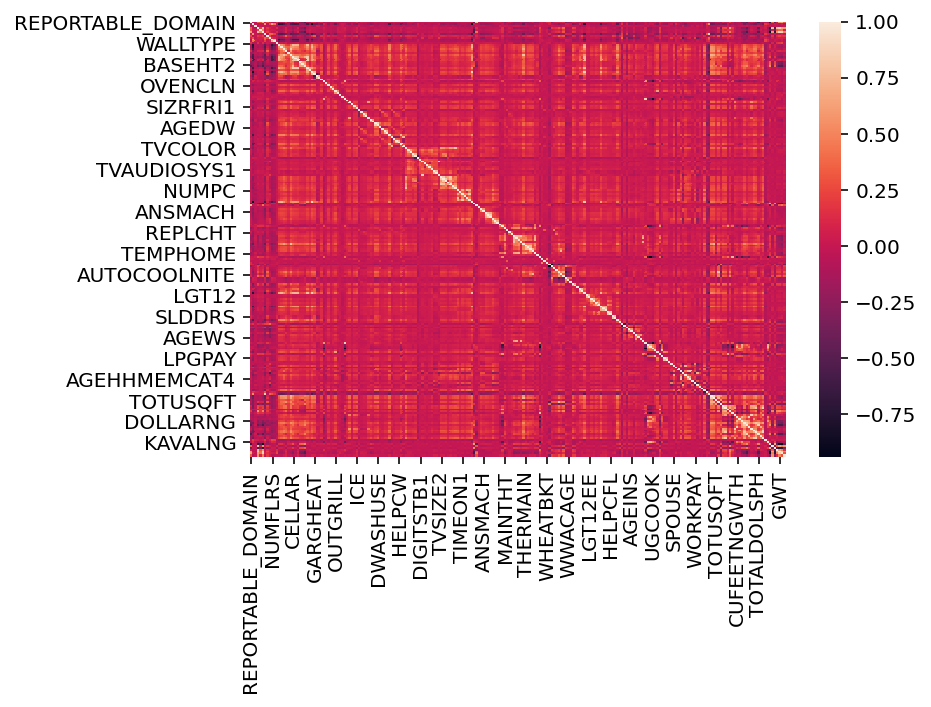

In [ ]:
sns.heatmap(recs_df.corr())

Even after removing redundant columns, there is still noticable correlation between some columns in data. When using linear regression, we ideally want the predictors to have no correlation with each other.

## Noise and Outliers

Linear Regression is sensitive to outliers and we must take care of them before building a prediction model.

Strategy for dealing with outliers: If the number of outliers found for a column make up less than 1% of the rows, remove the rows, else replace the outliers with mean.

Initially, the threshold was higher (I tried a range of values from 20% to 1%). I noticed that even with a low threshold as much as 2%, we would still lose about 25% of the rows after outlier removal. So in order not to lose too much data, I used the afromentioned strategy. I think it's not ideal, but a quick and general solution for now.

In [ ]:
rows = set()
for c,column in recs_df.iteritems():
  if column.dtype=='object':
    continue

  q25, q75 = percentile(column, 25), percentile(column, 75)
  iqr = q75 - q25
  cut_off = iqr * 1.5
  lower, upper = q25 - cut_off, q75 + cut_off
  outliers = recs_df[(recs_df[c] < lower) | (recs_df[c] > upper)] 
  if len(outliers)>0:
    percentage = outliers.shape[0]/recs_df.shape[0]*100
    print('%s #outliers: %d %d%%' % (c,outliers.shape[0],percentage))
    if percentage<1:
      recs_df.drop(index=outliers.index,inplace=True)

    else:
      recs_df[c].where(((recs_df[c] < lower) | (recs_df[c] > upper)),recs_df[c].mean())

TYPEHUQ #outliers: 1923 15%
NWEIGHT #outliers: 536 4%
CDD30YR #outliers: 692 5%
OCCUPYYRANGE #outliers: 224 1%
NUMFLRS #outliers: 1923 15%
NUMAPTS #outliers: 1923 15%
WALLTYPE #outliers: 909 7%
STORIES #outliers: 130 1%
BEDROOMS #outliers: 864 7%
NCOMBATH #outliers: 232 1%
NHAFBATH #outliers: 15 0%
TOTROOMS #outliers: 541 4%
CELLAR #outliers: 2463 20%
CRAWL #outliers: 5110 42%
CONCRETE #outliers: 2463 20%
FINBASERMS #outliers: 1972 16%
BASEHT2 #outliers: 2122 17%
ATTIC #outliers: 2463 20%
PRKGPLC1 #outliers: 2848 23%
SIZEOFDETACH #outliers: 2074 17%
OUTLET #outliers: 1126 9%
STOVENFUEL #outliers: 14 0%
OVENUSE #outliers: 87 0%
DEFROST #outliers: 451 3%
OUTGRILLFUEL #outliers: 2335 19%
NUMFRIG #outliers: 2884 24%
TYPERFR1 #outliers: 1079 9%
SIZRFRI1 #outliers: 70 0%
AGERFRI1 #outliers: 2866 24%
ESFRIG #outliers: 981 8%
REPLCFRI #outliers: 117 0%
HELPFRI #outliers: 57 0%
AGERFRI2 #outliers: 2849 24%
AGEFRZR #outliers: 1106 9%
AGEDW #outliers: 1622 13%
ESDISHW #outliers: 608 5%
REPLCDW #o

In [ ]:
recs_df.shape[0]

11054

## Skewness

Pandas profiling revealed that distribution of a lot of columns are higly skewed. Therefore the normality assumption for linear regression will be violated. We will detect skewed columns and try to transform into a normal distribution witn log transformation. The rule of thumb is if the skewness is not within [-1,1] range that the distribution is skewed. But in the profiling report, I noticed almost no column has a perfect normal distribuion and most have skewness around 2-3. So I set the threshold a bit higher in order not to transform too many columns and completely transform the data.

In [ ]:
for c in recs_df.columns:
  if recs_df[c].dtype=='object':
    continue
  skew = recs_df[c].skew()
  if skew>2 or skew<-2:
    print('%s skew before transforamtion: %f' % (c,skew))
    recs_df[c] = np.log(recs_df[c] + 1 - min(recs_df[c]))
    print('%s skew after log transforamtion: %f' % (c,recs_df[c].skew()))

NWEIGHT skew before transforamtion: 2.411620
NWEIGHT skew after log transforamtion: -0.531057
NUMFLRS skew before transforamtion: 5.038737
NUMFLRS skew after log transforamtion: 2.174175
NUMAPTS skew before transforamtion: 8.495619
NUMAPTS skew after log transforamtion: 2.372280
FINBASERMS skew before transforamtion: 2.183142
FINBASERMS skew after log transforamtion: 1.861462
SIZEOFDETACH skew before transforamtion: 2.062381
SIZEOFDETACH skew after log transforamtion: 1.818595
OUTLET skew before transforamtion: -3.801573
OUTLET skew after log transforamtion: -9.948413
NUMFRIG skew before transforamtion: 2.113035
NUMFRIG skew after log transforamtion: 1.422119
TYPERFR1 skew before transforamtion: -2.958464
TYPERFR1 skew after log transforamtion: -3.135793
ESFRIG skew before transforamtion: -2.093877
ESFRIG skew after log transforamtion: -2.938835
AGERFRI2 skew before transforamtion: 2.842178
AGERFRI2 skew after log transforamtion: 1.805676
AGEFRZR skew before transforamtion: 2.621389
AG

## Scaling

The unit of the values in the columns are not uniform. Some came from multi-answer questions so only have a categorical value. Some have continues values with large numbers. 

However, we will not use nueral networks or linear models sensitive to unscaled data.So we don't have to worry about this much for now. (Also, linear regression makes no assumption about the scale of the variables).



## Train Test Sets

In [ ]:
X = recs_df.loc[:,recs_df.columns!='KWH'].copy()
y = recs_df['KWH'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Dealing with Categorical Values

For dealing with categorical values, we'll use label encoding. We will fit the encoder only on training set so we don't leak any information to test set and help the models cheat!

In [ ]:
categorical_columns = [c for c in recs_df.columns if recs_df[c].dtype=='object']
for c in categorical_columns:
  print(c)
  encoder = LabelEncoder()
  encoder.fit(X_train[c].values)
  X_train[c] = encoder.transform(X_train[c])
  X_test[c] = encoder.transform(X_test[c])

UR
IECC_Climate_Pub


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Prediction 

We'll first try two separate regression models to predict KWH. Then we'll see if we can improve the prediction by stacking the two and building an ensemble model. 

In [ ]:
from sklearn.linear_model import LinearRegression

estimators = [('lgbm', GradientBoostingRegressor(random_state=42,max_depth=5)),
              ('lr', LinearRegression()),
              ('rc', RidgeCV())]

stack = StackingRegressor(estimators=estimators[:-1],final_estimator=estimators[-1][1])
print("Individual resutls:")
for estimator in estimators:
  print("model: %s, score: %f" %(estimator[0],estimator[1].fit(X_train, y_train).score(X_test, y_test)))
  
print("################\nEnsemble result")
stack.fit(X_train, y_train).score(X_test, y_test)

Individual resutls:
model: lgbm, score: 0.979457
model: lr, score: 0.942079
model: rc, score: 0.942155
################
Ensemble result


0.9806199356547125